In [1]:
import torch, torchdata, torchtext
from torch import nn

import random, math, time

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

#make our work comparable if restarted the kernel
SEED = 1234
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

cuda


In [2]:
from datasets import load_dataset

df = load_dataset("fancyzhx/ag_news")


# 0  -> World
# 1  ->Sports
# 2  -> Business 
# 3   -> Sci/Tech


In [3]:
train,test=df['train'],df['test']
train=train.to_pandas()
test=test.to_pandas()
train.shape,test.shape

((120000, 2), (7600, 2))

In [4]:
from sklearn.model_selection import train_test_split
train,valid=train_test_split(train,test_size=0.3)
train.shape,valid.shape

((84000, 2), (36000, 2))

In [5]:
from torchtext.data.utils import get_tokenizer
tokenizer = get_tokenizer('spacy', language='en_core_web_sm')
tokens = tokenizer("We are learning pytorch ")  
tokens

['We', 'are', 'learning', 'pytorch']

In [6]:
from torchtext.vocab import build_vocab_from_iterator
def yield_tokens(df):
    for i,(text,label) in train.iterrows():
        yield(tokenizer(text))

vocab=build_vocab_from_iterator(yield_tokens(train),specials=['<unk>','<pad>','<eos>','<bos>'])
vocab.set_default_index(vocab['<unk>'])
mapping=vocab.get_itos()


In [7]:
from torchtext.vocab import FastText
fast_vectors = FastText(language='simple') 
fast_embedding = fast_vectors.get_vecs_by_tokens(vocab.get_itos()).to(device)

In [8]:

from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence
text_pipeline=lambda x:vocab(tokenizer(x))
pad_idx=vocab['<pad>']

In [9]:
from torch.utils.data import Dataset

class TextClassificationDataset(Dataset):
    def __init__(self, dataframe):
        self.texts = dataframe['text'].tolist()
        self.labels = dataframe['label'].tolist()

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.texts[idx], self.labels[idx]

# Create datasets
train_dataset = TextClassificationDataset(train)
valid_dataset = TextClassificationDataset(valid)
test_dataset = TextClassificationDataset(test)

In [10]:
def collate_batch(batch):
    text_sequence = []
    label_sequence = []
    length_list = []
    for text, label in batch:
        preprocess_seq = torch.tensor(text_pipeline(text))
        text_sequence.append(preprocess_seq)
        label_sequence.append(label)
        length_list.append(preprocess_seq.size(0))
    return torch.tensor(label_sequence, dtype=torch.int64), pad_sequence(text_sequence, padding_value=pad_idx, batch_first=True), torch.tensor(length_list)

In [11]:
batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size,
                              shuffle=True, collate_fn=collate_batch)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size,
                              shuffle=True, collate_fn=collate_batch)
test_loader  = DataLoader(test_dataset, batch_size=batch_size,
                             shuffle=True, collate_fn=collate_batch)

In [12]:
class LSTM(nn.Module):
    def __init__(self,input_dim,embed_dim,hidden_dim,output_dim,num_layers,bidirectional,dropout):
        super().__init__()
        self.embedding=nn.Embedding(input_dim,embed_dim,padding_idx=pad_idx)
        self.lstm=nn.LSTM(embed_dim,hidden_dim,num_layers=num_layers,bidirectional=bidirectional,dropout=dropout,batch_first=True)
        self.fc=nn.Linear(hidden_dim *2,output_dim)

    def forward(self,text,text_length):
        embed=self.embedding(text)
        packed_embed= nn.utils.rnn.pack_padded_sequence(embed,text_length.to('cpu'),enforce_sorted=False, batch_first=True)
        packed_output,(hn,cn)=self.lstm(packed_embed)

        hn=torch.cat((hn[-2,:,:],hn[-1,:,:]),dim=1)

        return self.fc(hn)

    

In [13]:
def initialize_weights(m):
    if isinstance(m,nn.Linear):
        nn.init.xavier_normal_(m.weight)
        nn.init.zeros_(m.bias)
    elif isinstance(m,nn.LSTM):
        for name, param in m.named_parameters():
            if 'bias' in name:
                nn.init.zeros_(param)
            elif 'weight' in name:
                nn.init.orthogonal_(param)

In [14]:
input_dim  = len(vocab)
hid_dim    = 256
emb_dim    = 300        
output_dim = 4 
num_layers = 2
bidirectional = True
dropout = 0.5

model = LSTM(input_dim, emb_dim, hid_dim, output_dim, num_layers, bidirectional, dropout).to(device)
model.apply(initialize_weights)
model.embedding.weight.data = fast_embedding 

In [15]:

import torch.optim as optim
lr =1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

In [16]:
def accuracy(preds, y):
    
    predicted = torch.max(preds.data, 1)[1]
    batch_corr = (predicted == y).sum()
    acc = batch_corr / len(y)
    
    return acc

def train_model(model, loader, optimizer, criterion, loader_length):
    epoch_loss = 0
    epoch_acc = 0
    model.train() 
    
    for i, (label, text, text_length) in enumerate(loader): 
        label = label.to(device) #(batch_size, )
        text = text.to(device) #(batch_size, seq len)
                
        #predict
        predictions = model(text, text_length)
        
        loss = criterion(predictions, label)
        acc  = accuracy(predictions, label)
        
        #backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
                        
    return epoch_loss / loader_length, epoch_acc / loader_length


def evaluate_model(model, loader, criterion, loader_length):
    epoch_loss = 0
    epoch_acc = 0
    model.eval()
    
    with torch.no_grad():
        for i, (label, text, text_length) in enumerate(loader): 
            label = label.to(device) #(batch_size, )
            text  = text.to(device)  #(seq len, batch_size)

            predictions = model(text, text_length)
            
            loss = criterion(predictions, label)
            acc  = accuracy(predictions, label)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / loader_length, epoch_acc / loader_length





In [17]:

train_loader_length = len(list(iter(train_loader)))
val_loader_length   = len(list(iter(valid_loader)))
test_loader_length  = len(list(iter(test_loader)))

In [18]:
import time
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs


In [19]:
best_valid_loss = float('inf')
num_epochs      = 8

save_path = f'models/{model.__class__.__name__}.pt'

train_losses = []
train_accs = []
valid_losses = []
valid_accs = []

for epoch in range(num_epochs):
    
    start_time = time.time()

    train_loss, train_acc = train_model(model, train_loader, optimizer, criterion, train_loader_length)
    valid_loss, valid_acc = evaluate_model(model, valid_loader, criterion, val_loader_length)
    
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    valid_losses.append(valid_loss)
    valid_accs.append(valid_acc)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), save_path)
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epoch: 01 | Time: 1m 0s
	Train Loss: 0.326 | Train Acc: 88.60%
	 Val. Loss: 0.240 |  Val. Acc: 92.14%
Epoch: 02 | Time: 1m 0s
	Train Loss: 0.149 | Train Acc: 95.10%
	 Val. Loss: 0.226 |  Val. Acc: 92.34%
Epoch: 03 | Time: 1m 0s
	Train Loss: 0.082 | Train Acc: 97.21%
	 Val. Loss: 0.291 |  Val. Acc: 91.86%
Epoch: 04 | Time: 1m 0s
	Train Loss: 0.046 | Train Acc: 98.45%
	 Val. Loss: 0.321 |  Val. Acc: 91.18%
Epoch: 05 | Time: 1m 0s
	Train Loss: 0.027 | Train Acc: 99.09%
	 Val. Loss: 0.428 |  Val. Acc: 91.26%
Epoch: 06 | Time: 1m 0s
	Train Loss: 0.018 | Train Acc: 99.38%
	 Val. Loss: 0.478 |  Val. Acc: 91.00%
Epoch: 07 | Time: 1m 0s
	Train Loss: 0.013 | Train Acc: 99.57%
	 Val. Loss: 0.540 |  Val. Acc: 90.31%
Epoch: 08 | Time: 1m 0s
	Train Loss: 0.010 | Train Acc: 99.69%
	 Val. Loss: 0.581 |  Val. Acc: 90.58%


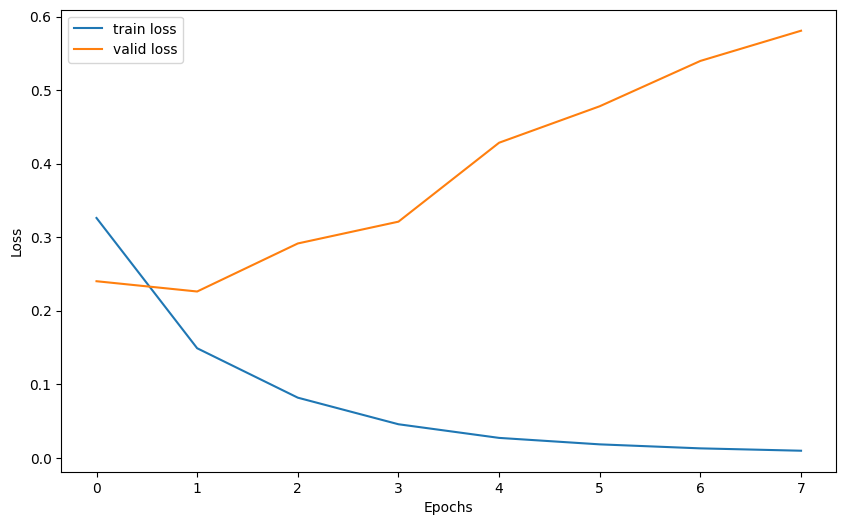

In [21]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(train_losses, label='train loss')
ax.plot(valid_losses, label='valid loss')
plt.legend()
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
plt.show()


In [23]:
model.load_state_dict(torch.load(save_path))

test_loss, test_acc = evaluate_model(model, test_loader, criterion, test_loader_length)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 0.238 | Test Acc: 91.84%


In [24]:

test_str = "Google is now falling nonstop. The price is really bad now."
text = torch.tensor(text_pipeline(test_str)).to(device)
text

tensor([  195,    27,   228,  1855, 15463,     6,    21,   393,    27,  2358,
         1285,   228,     6], device='cuda:0')

In [25]:
text_list = [x.item() for x in text]
text = text.reshape(1, -1)  #because batch_size is 1
text_length = torch.tensor([text.size(1)]).to(dtype=torch.int64)


In [35]:
def predict(text, text_length):
    with torch.no_grad():
        output = model(text, text_length).squeeze(1)
        predicted = torch.max(output.data, 1)[1]
        return predicted


In [41]:
def text_input(test_str):
    text = torch.tensor(text_pipeline(test_str)).to(device)
    text_list = [x.item() for x in text]
    text = text.reshape(1, -1) 
    text_length = torch.tensor([text.size(1)]).to(dtype=torch.int64)
    label=predict(text,text_length)
    print(label.item())


In [45]:
text_input("Apple will defend a lawsuit against a person")

3


In [46]:
text_input("Google will defend a lawsuit against a person")

3


In [48]:
text_input("India's Tata expands regional footprint via NatSteel buyout (AFP) AFP - India's Tata Iron and Steel Company Ltd. took a strategic step to expand its Asian footprint with the announcement it will buy the Asia-Pacific steel operations of Singapore's NatSteel Ltd.")

2


In [49]:
text_input("Jackson Squares Off With Prosecutor SANTA MARIA, Calif. - Fans of Michael Jackson erupted in cheers Monday as the pop star emerged from a double-decker tour bus and went into court for a showdown with the prosecutor who has pursued him for years on child molestation charges..")

0
